# Tarea 1: Procesamiento de Datos Masivos

Agustín Urrutia

Diego Pollack

## Setup

In [ ]:
!pip install unidecode
!pip install datasketch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 5.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 2.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from unidecode import unidecode
import time
from collections import defaultdict, Counter
from scipy.sparse import csr_matrix, lil_matrix, coo_matrix
from datasketch import MinHash
import numpy as np
import re
from scipy import sparse
import random

In [ ]:
from pandas.core.frame import DataFrame

In [ ]:
!gdown 1PQon6SC1z5dpbadK2ehZShPImp2Yhcic

Downloading...
From: https://drive.google.com/uc?id=1PQon6SC1z5dpbadK2ehZShPImp2Yhcic
To: /content/tweets_2022_abril_junio.csv
100% 818M/818M [00:13<00:00, 61.5MB/s]


In [ ]:
df = pd.read_csv('tweets_2022_abril_junio.csv')

In [ ]:
df

## Limpieza de los datos y armar formato adecuado

In [ ]:
columns_to_drop = ['id', 'created_at', 'favorite_count', 'retweet_count']
df = df.drop(columns=columns_to_drop)

In [ ]:
final_df = df.assign(text=df['text'].str.replace('^RT\s+@\w+:\s+', '', regex=True))
final_df

In [ ]:
# Create a defaultdict with a list as the default value type
index_dict = defaultdict(list)

# Iterate over the rows of the DataFrame
for index, row in final_df.iterrows():
    text = row['text']
    index_dict[text].append(index)

In [ ]:
# Convert the defaultdict to a new DataFrame
new_df = pd.DataFrame({'text': list(index_dict.keys()), 'indices': list(index_dict.values())})
new_df['text'] = new_df['text'].apply(lambda x: unidecode(str(x).lower()))
new_df = new_df.dropna(subset=['text'])
new_df

## Extracción de los shingles

In [ ]:
def get_shingles(df: pd.DataFrame, shingle_size: int = 4, echo: bool = True) -> dict:
    start_time = time.time()

    all_shingles = Counter()

    # Extract text, tags, and hashtags into separate columns
    df['text'] = df['text'].fillna('')

    # Process text column
    text_values = df['text'].tolist()
    for text_value in text_values:
        for i in range(len(text_value) - shingle_size + 1):
            shingle = text_value[i : i + shingle_size]
            all_shingles[shingle] += 1

    if echo:
        print(f"Finish getting the shingles of {'{:_}'.format(len(df))} rows of the df")
        print(f"Total shingles: {'{:_}'.format(len(all_shingles))}")
        print(f"The process took {round(time.time() - start_time, 3)} seconds")

    return all_shingles


In [ ]:
SHINGLE_SIZE = 4

In [ ]:
all_shingles = get_shingles(new_df, shingle_size=SHINGLE_SIZE)

In [ ]:
count = Counter()

MAX_SIZE_STUDY = 1
for value in all_shingles.values():
    if value <= MAX_SIZE_STUDY:
        count[value] += 1

rest = len(all_shingles)

for i in range(0, MAX_SIZE_STUDY + 1):
    value = count[i]
    print(f"Repetido {i} veces: {value}")
    rest -= value
    print(f"Restantes: {rest}")
    print("-----------")

Pensemos cómo funciona LSH con minhash: Tendremos una matriz en que cada fila representa un shingle y cada columna un tweet. Si reordenamos las filas para ver el índice de la fila con el primer shingle contenido y tenemos shingles que tienen muy baja aparición, implicará que el hash tendrá muy pocos elementos. Es por esto que se toma la desición de eliminar los shingles con apariciones bajas. Podemos observar en el estudo anterior que de cerca de 100.000 shingles o más, varios se repiten menos de 10 veces, lo que significa una probabilidad muy baja de que al hacer el minhash coicidan dos tweets en el hash.

In [ ]:
# print(f"Initial size: {len(all_shingles)}")        

# DELETE_SHORTERS_THAN = 1

# keys_to_delete = []

# for key, value in all_shingles.items():
#     if value <= DELETE_SHORTERS_THAN:
#         keys_to_delete.append(key)

# eliminados = 0
# for key in keys_to_delete:
#     eliminados += 1
#     del all_shingles[key]

# print(f"Final size: {len(all_shingles)}")

## Inspirado en ejemplo visto en clases

In [ ]:
all_shingles_set = set(all_shingles.keys())

# Crear un diccionario para mapear cada shingle a su índice en la matriz
shingles_index = {shingle: index for index, shingle in enumerate(all_shingles_set)}

In [ ]:
def crear_hash(a, b, p, n):
    def f(x):
        return ((a * x + b) % p) % n
    return f


hash_list = []
n = len(all_shingles_set)
p = 2_134_519
TOTAL_HASHES = 16
for i in range(TOTAL_HASHES):
    a = random.randint(1, p-1)
    b = random.randint(0, p-1)
    hash_list.append(crear_hash(a,b,p,n))

In [ ]:
s_time = time.time()

matrix_MinHash = np.full((TOTAL_HASHES, len(new_df)), 5_000_000)

# Recorrer los tweets del DataFrame
for i, tweet in enumerate(new_df['text']):

    if i % 50_000 == 0:
      print(i)

    shingles_in_tweet = {tweet[i:i+SHINGLE_SIZE] for i in range(len(tweet) - SHINGLE_SIZE + 1)}
    
    # Actualizar los valores en la columna si un shingle está presente en el tweet
    column_i = np.full(TOTAL_HASHES, np.inf)
    
    for shingle in shingles_in_tweet:
        shingle_index = shingles_index[shingle]

        hash_values = np.array([hash_func(shingle_index) for hash_func in hash_list])
        column_i = np.minimum(column_i, hash_values)
    
    matrix_MinHash[:, i] = column_i

# Medir el tiempo de ejecución
e_time = time.time()
print(e_time - s_time)

0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000
700000
750000
800000
850000
900000
950000
1000000
1050000
1100000
1150000
1200000
1250000
1300000
1350000
1400000
1056.3716514110565


In [ ]:
minhash_sets = [set(minhash) for minhash in matrix_MinHash]

In [ ]:
threshold = 0.3
similar_columns_metodo_1 = []

# Iterar a través de las columnas de los MinHash signatures
for i in range(len(minhash_sets)):
    for j in range(i + 1, len(minhash_sets)):
        similarity = len(minhash_sets[i] & minhash_sets[j]) / len(minhash_sets[i] | minhash_sets[j])
        if similarity >= threshold:
            similar_columns_metodo_1.append((i, j, similarity))

In [ ]:
similar_columns_metodo_1

[(1, 6, 0.3101338432122371),
 (1, 8, 0.3109139582734131),
 (1, 10, 0.30462084257206207),
 (1, 12, 0.3263878268848448),
 (1, 15, 0.3006117033238879),
 (2, 6, 0.30217695226682645),
 (2, 8, 0.3171336938455416),
 (2, 12, 0.315306749073909),
 (2, 15, 0.3045908658420552),
 (3, 12, 0.30550049554013875),
 (5, 8, 0.32208491374036463),
 (5, 12, 0.30424442005122576),
 (5, 15, 0.33787701541122017),
 (6, 8, 0.32686832740213523),
 (6, 10, 0.31687946293427355),
 (6, 12, 0.33923088731961926),
 (6, 13, 0.3050569658205077),
 (6, 15, 0.3131524949829759),
 (7, 10, 0.32824450695658786),
 (7, 12, 0.3320416953549069),
 (8, 10, 0.31536269191872757),
 (8, 12, 0.34139008899595835),
 (8, 13, 0.30207707759531155),
 (8, 15, 0.35015963622291024),
 (10, 11, 0.30867082437054116),
 (10, 12, 0.3567797454895837),
 (10, 13, 0.31978862038889744),
 (10, 14, 0.30558250857105895),
 (10, 15, 0.3033868689121868),
 (11, 12, 0.3165280324862457),
 (12, 13, 0.3384051329055912),
 (12, 14, 0.3100309671679584),
 (12, 15, 0.3303816362

In [ ]:
print(new_df.iloc[6]['text'])
print(new_df.iloc[1]['text'])

@unveranonaranja @ruidosafest @franciscamusic @giovannaroa @diegosporzio gracias querida 
manana jueves a las 18hrs. comienza nuestro programa #dignificareltrabajo en @uchileradio, con la presidenta de @conve...


In [ ]:
# Ordenar la lista de tuplas por el tercer elemento en orden descendente
lista_ordenada = sorted(similar_columns_metodo_1, key=lambda x: x[2], reverse=True)

# Obtener el top 5
top_5 = lista_ordenada[:5]

print(top_5)

for x in lista_ordenada[:5]:
  x0 = new_df.iloc[x[0]]['text']
  x1 = new_df.iloc[x[1]]['text']
  print(f"""
Similitud: {x[2]}
  {x[0]}: {x0}
  {x[1]}: {x1}""")

all_n = set()
for x, y,_  in top_5:
    all_n.add(x)
    all_n.add(y)

for z in all_n:
    print(new_df.iloc[z]['text'])

## Inspirado en [pdf usado en clases](http://www.mmds.org/mmds/v2.1/ch03-lsh.pdf)

Lo que se hace en esta implementación, es hacer una matriz dispersa que indique los shingles presentes en cada tweet. Luego, se hacen permutaciónes de las filas de esta matriz dispera, y se extrae el índice de la primera fila no vacía para cada columna para así construir la firma. 

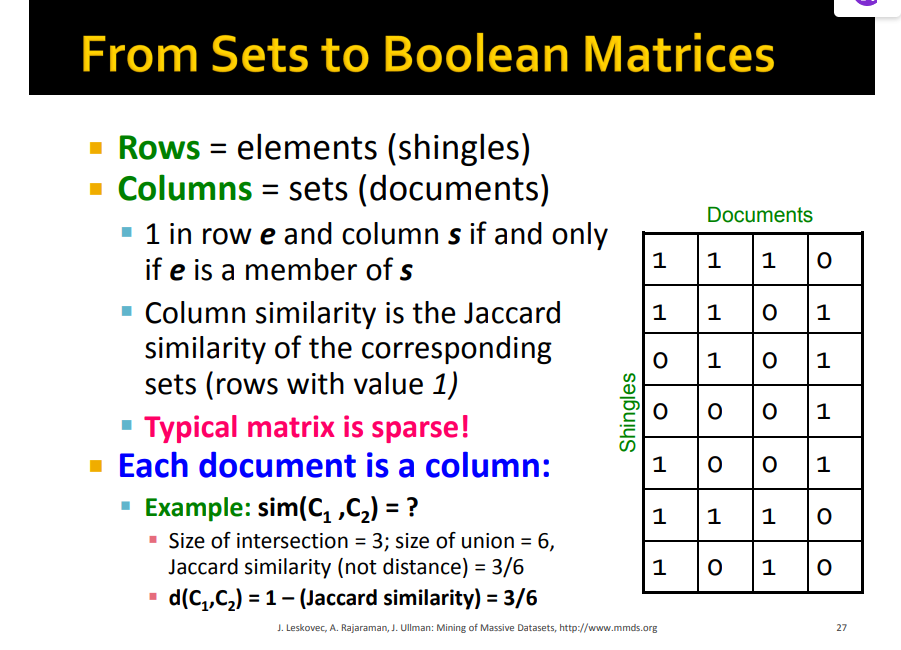

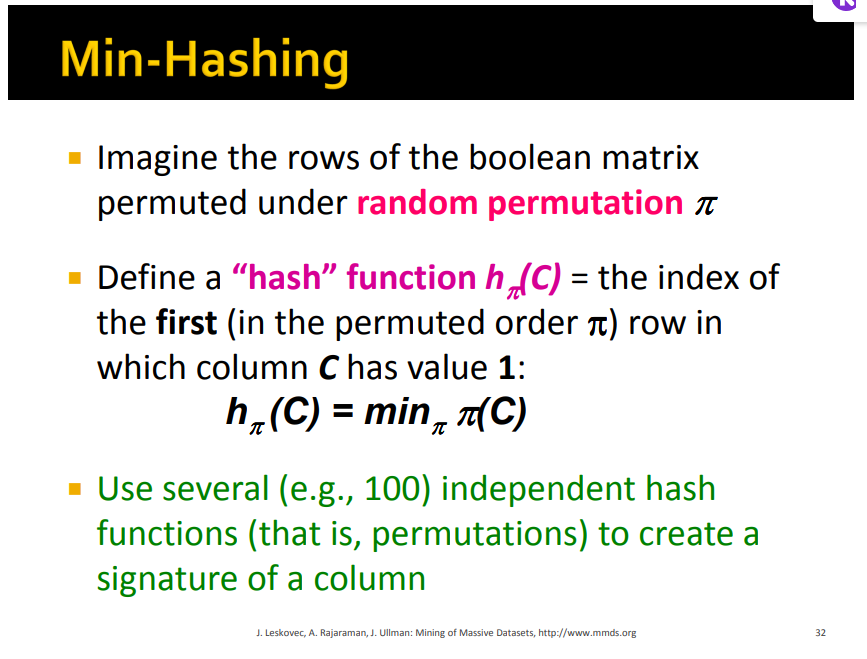

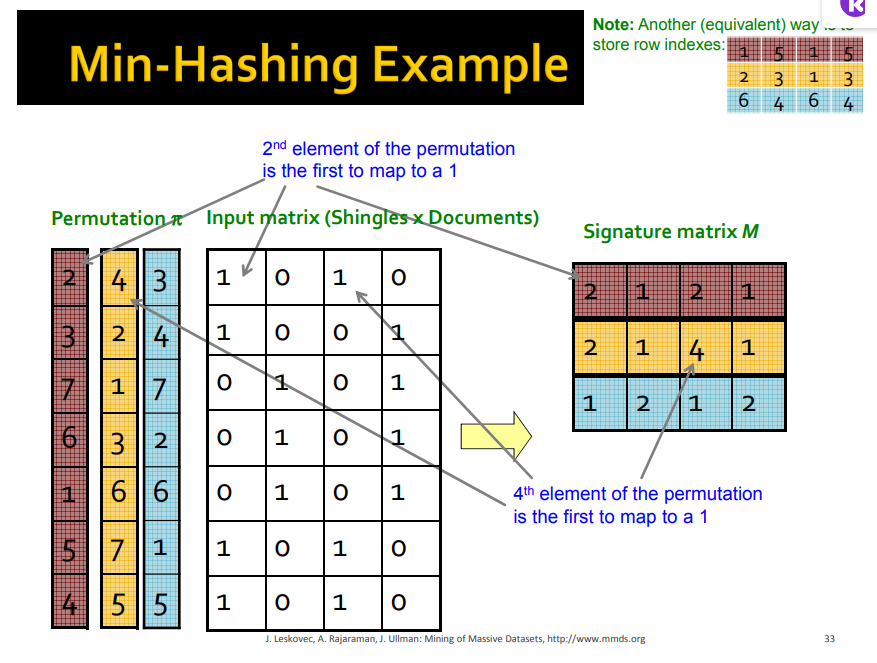

En algunas ejecuciones hechas, se vieron resultados con mayor velocidad al eliminar los shingles con baja aparición. Esto sucedía ya que, por ejemplo, si un shingle aparecía unicamente una vez, solo habría un tweet que potencialmente pueda llegar a aquella firma; por lo que no era tan representativo para encontrar similitud con otros tweets

In [ ]:
all_shingles_set = set(all_shingles.keys())

In [ ]:
s_time = time.time()

# Crear un diccionario para mapear cada shingle a su índice en la matriz
shingle_index = {shingle: index for index, shingle in enumerate(all_shingles_set)}

# Crear una matriz dispersa inicialmente llena de ceros
n_rows = len(all_shingles_set)
n_cols = len(new_df)
row_indices = []
col_indices = []
data = []

# Recorrer los tweets del DataFrame
for i, tweet in enumerate(new_df['text']):
    # Obtener los shingles presentes en el tweet
    shingles_in_tweet = {tweet[i:i+SHINGLE_SIZE] for i in range(len(tweet) - SHINGLE_SIZE + 1)}
    
    # Actualizar los valores en la matriz si un shingle está presente en el tweet
    for shingle in shingles_in_tweet:
        if shingle in shingle_index:
            row_indices.append(shingle_index[shingle])
            col_indices.append(i)
            data.append(1)


# Construir la matriz dispersa en formato CSR
matrix = csr_matrix((data, (row_indices, col_indices)), shape=(n_rows, n_cols))

# Medir el tiempo de ejecución
e_time = time.time()
print(e_time - s_time)

181.66894626617432


**SI YA CORRISTE LO ANTERIOR, CONVIENE GUARDARLO EN CASO DE QUE SE CAIGA EL COLAB**. Descomenta lo necesario del siguiente cuadro. Correr lo anterior debiese tomar unos 2 a 3 minitos

In [ ]:
# sparse.save_npz('shingles_matrix.npz', matrix)
# loaded_matrix = sparse.load_npz('shingles_matrix.npz')
loaded_matrix = matrix

In [ ]:
N = 16  # Número de iteraciones
num_rows, num_cols = loaded_matrix.shape

minhash_matrix = np.zeros((N, num_cols), dtype=int)

row_indices = list(range(num_rows))  # Generar una lista de índices de fila

for i in range(N):
    print("Iteración", i)

    # Mezclar las filas de la matriz en su lugar
    random.shuffle(row_indices)

    # Obtener el índice de la primera fila no cero en cada columna
    first_nonzero_rows = np.argmax(loaded_matrix[row_indices, :], axis=0)

    # Almacenar el vector de índices en una fila de minhash_matrix
    minhash_matrix[i, :] = first_nonzero_rows

Iteración 0
Iteración 1
Iteración 2
Iteración 3
Iteración 4
Iteración 5
Iteración 6
Iteración 7
Iteración 8
Iteración 9
Iteración 10
Iteración 11
Iteración 12
Iteración 13
Iteración 14
Iteración 15


**AL IGUAL QUE ANTES, CONVIENE GUARDAR LA MATRIZ CALCULADA** Tiempo estimado de ejecución de celda anterior: 8 minutos

In [ ]:
# np.save('minhash_matrix.npy', minhash_matrix)
minhash_matrix = np.load('minhash_matrix.npy')

In [ ]:
# Convertir los MinHash signatures en conjuntos
minhash_sets = [set(minhash) for minhash in minhash_matrix]

In [ ]:
threshold = 0.3
similar_columns = []

# Iterar a través de las columnas de los MinHash signatures
for i in range(len(minhash_sets)):
    for j in range(i + 1, len(minhash_sets)):
        similarity = len(minhash_sets[i] & minhash_sets[j]) / len(minhash_sets[i] | minhash_sets[j])
        if similarity >= threshold:
            similar_columns.append((i, j, similarity))

In [ ]:
similar_columns

[(0, 9, 0.3029560380553758),
 (0, 10, 0.3171501952459575),
 (0, 12, 0.3156169184460806),
 (0, 13, 0.3140908221013205),
 (1, 3, 0.3145806579077349),
 (1, 4, 0.3341953751769703),
 (1, 5, 0.3193337233964748),
 (1, 7, 0.3529538177207573),
 (1, 9, 0.3434286320104605),
 (1, 10, 0.3376008360821712),
 (1, 11, 0.3813082957563778),
 (1, 12, 0.37533002233997376),
 (1, 13, 0.345446972457958),
 (1, 15, 0.30810389031323154),
 (2, 9, 0.30099303112222026),
 (2, 10, 0.31168948475424857),
 (2, 12, 0.3162548365017949),
 (2, 13, 0.31013860265890814),
 (3, 9, 0.3151152987116719),
 (3, 10, 0.32183843933456974),
 (3, 11, 0.3060527863069184),
 (3, 12, 0.33440750187088597),
 (3, 13, 0.32239709797267646),
 (4, 9, 0.3147958847193827),
 (4, 10, 0.31567868227774193),
 (4, 11, 0.3206677858608469),
 (4, 12, 0.33792383754747324),
 (4, 13, 0.3232295263535084),
 (5, 9, 0.30365626605033386),
 (5, 10, 0.30590246023298),
 (5, 11, 0.30911758313410126),
 (5, 12, 0.32244091874668085),
 (5, 13, 0.31033772652388797),
 (6, 10, 

In [ ]:
# Ordenar la lista de tuplas por el tercer elemento en orden descendente
lista_ordenada = sorted(similar_columns, key=lambda x: x[2], reverse=True)

# Obtener el top 5
top_5 = lista_ordenada[:5]

print(top_5)

for x in lista_ordenada[:5]:
  x0 = new_df.iloc[x[0]]['text']
  x1 = new_df.iloc[x[1]]['text']
  print(f"""
Similitud: {x[2]}
  {x[0]}: {x0}
  {x[1]}: {x1}""")

all_n = set()
for x, y,_  in top_5:
    all_n.add(x)
    all_n.add(y)

for z in all_n:
    print(new_df.iloc[z]['text'])

[(1, 11, 0.3813082957563778), (1, 12, 0.37533002233997376), (12, 13, 0.3645975388663383), (11, 12, 0.3613706028317034), (10, 12, 0.3554390325220501)]

Similitud: 0.3813082957563778
  1: manana jueves a las 18hrs. comienza nuestro programa #dignificareltrabajo en @uchileradio, con la presidenta de @conve...
  11: por esto no apruebo la propuesta de cpr stingo :aca ganamos nosotros y vamos a hacer la cpr  como nosotros queremos y no...

Similitud: 0.37533002233997376
  1: manana jueves a las 18hrs. comienza nuestro programa #dignificareltrabajo en @uchileradio, con la presidenta de @conve...
  12: @teanval0207 @izkia @arturozunigaj excelente...

Similitud: 0.3645975388663383
  12: @teanval0207 @izkia @arturozunigaj excelente...
  13: @mcubillossigall https://t.co/gkg5pwbzhz

Similitud: 0.3613706028317034
  11: por esto no apruebo la propuesta de cpr stingo :aca ganamos nosotros y vamos a hacer la cpr  como nosotros queremos y no...
  12: @teanval0207 @izkia @arturozunigaj excelente...

S